In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, plot_roc_curve, plot_confusion_matrix
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from sklearn.utils import resample
from sklearn import metrics

pd.set_option('display.max_columns', 100)

In [224]:
d = pd.read_csv('diabetes.csv')
d.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## EDA

In [225]:
d.shape

(768, 9)

In [226]:
d.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [227]:
print('count of 0\'s in columns:')
d[d[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']] == 0].count()

count of 0's in columns:


Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### Zero values for glucose, bp, skin thickness, insulin and bmi
  - Pregnancies, pedigree function, age and outcome: zero values makes sense here so we leave them
  - For glucose, bp, skin thickness, insulin and bmi, we will investigate how to impute. There should be a value for those rows since they are measurable vital signs
  - For now however, we'll impute nans so we can better visualize our data before impution 

In [228]:
# replacing zeros to nans for each column mentioned above

d_nan = d[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI']].replace(0,np.nan)


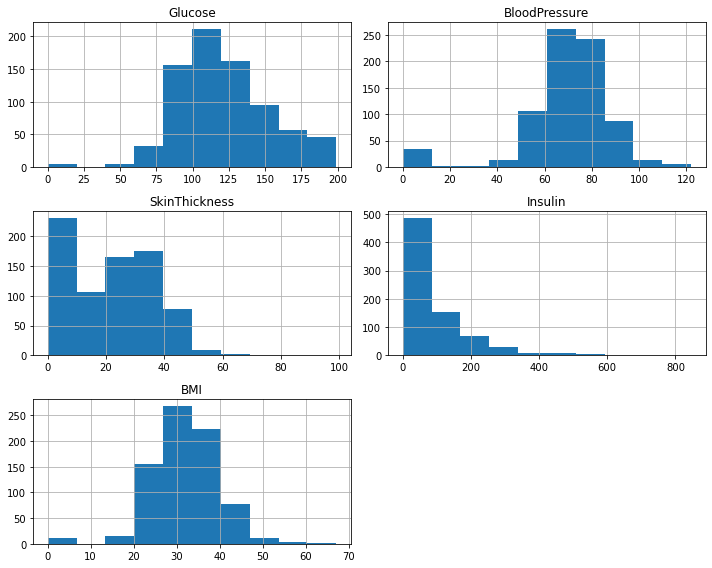

In [229]:
# original hist

d[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI']].hist(figsize=(10,8));
plt.tight_layout()

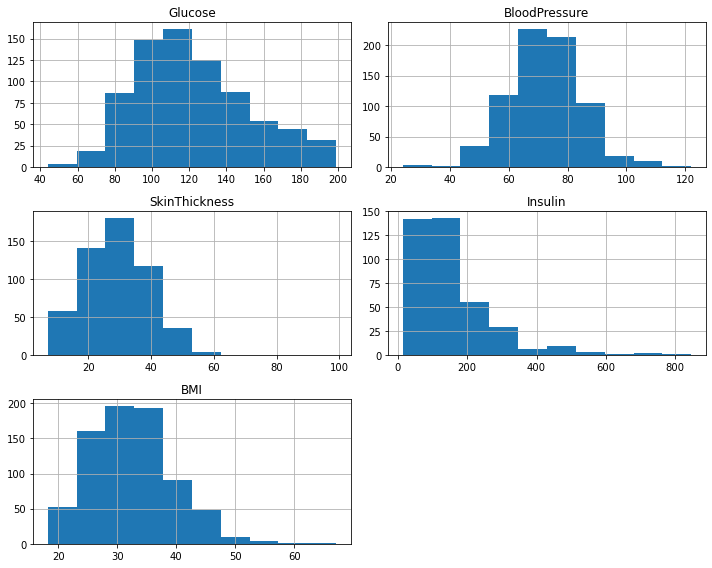

In [230]:
# hist with nans
d_nan.hist(figsize=(10,8));
plt.tight_layout()

### Except for insulin, the data is fairly normal 
  - Lets look at averages for those who have diabetes and those who do not
 

In [231]:
# first merge tables to make third working df, d_new

d_new = d_nan.copy()
d_new['Pregnancies'] = d.Pregnancies
d_new['DiabetesPedigreeFunction'] = d.DiabetesPedigreeFunction
d_new['Age'] = d.Age
d_new['Outcome'] = d.Outcome
d_new.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DiabetesPedigreeFunction,Age,Outcome
0,148.0,72.0,35.0,NaN,33.6,6,0.627,50,1
1,85.0,66.0,29.0,NaN,26.6,1,0.351,31,0
2,183.0,64.0,NaN,NaN,23.3,8,0.672,32,1
3,89.0,66.0,23.0,94.0,28.1,1,0.167,21,0
4,137.0,40.0,35.0,168.0,43.1,0,2.288,33,1


### Grouping features by outcome, getting their mean and medians for statistical tests

In [232]:
d_new.groupby(['Outcome'])[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age']].agg(['mean', 'count', 'std'])

Glucose                  BloodPressure                   \
               mean count        std          mean count        std   
Outcome                                                               
0        110.643863   497  24.776906     70.877339   481  12.161223   
1        142.319549   266  29.599199     75.321429   252  12.299866   

        SkinThickness                      Insulin                    \
                 mean count        std        mean count         std   
Outcome                                                                
0           27.235457   361  10.026491  130.287879   264  102.482237   
1           33.000000   180  10.327595  206.846154   130  132.699898   

               BMI                 DiabetesPedigreeFunction                  \
              mean count       std                     mean count       std   
Outcome                                                                       
0        30.859674   491  6.560737                 0.429734   500  0.299085   
1        35.406767   266  6.614982                 0.550500   268  0.372354   

        Pregnancies                        Age                   
               mean count       std       mean count        std  
Outcome                                                          
0          3.298000   500  3.017185  31.190000   500  11.667655  
1          4.865672   268  3.741239  37.067164   268  10.968254

In [233]:
d_new.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DiabetesPedigreeFunction,Age,Outcome
0,148.0,72.0,35.0,NaN,33.6,6,0.627,50,1
1,85.0,66.0,29.0,NaN,26.6,1,0.351,31,0
2,183.0,64.0,NaN,NaN,23.3,8,0.672,32,1
3,89.0,66.0,23.0,94.0,28.1,1,0.167,21,0
4,137.0,40.0,35.0,168.0,43.1,0,2.288,33,1


In [234]:
# statistical tests on averages 
gl0 = d.query('Outcome == 0')["Glucose"]
gl1 = d.query('Outcome == 1')["Glucose"]
t_stat, pval = stats.f_oneway(gl0,gl1)
t_stat, pval

(213.1617521780386, 8.935431645287658e-43)

In [235]:
gavg = d_new.groupby(['Outcome'])['Glucose'].mean()
bpmed = d_new.groupby(['Outcome'])['BloodPressure'].median()
stmed = d_new.groupby(['Outcome'])['SkinThickness'].median()
inmed = d_new.groupby(['Outcome'])['Insulin'].median()
bmimed = d_new.groupby(['Outcome'])['BMI'].median()

### Median is better to use if the data has outliers, lets take a look

<AxesSubplot:>

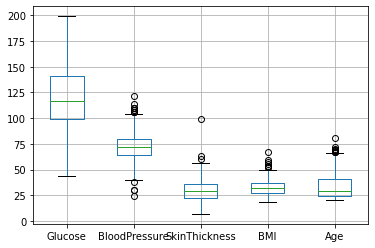

In [236]:
d_new.boxplot(column=['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Age'])

<AxesSubplot:>

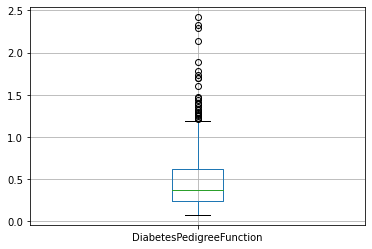

In [237]:
d_new.boxplot(column=['DiabetesPedigreeFunction'])

### Use mean for glucose and median for the rest 

In [238]:
d_new.loc[(d_new['Outcome'] == 0 ) & (d_new['Glucose'].isnull()), 'Glucose'] = gavg[0]
d_new.loc[(d_new['Outcome'] == 1 ) & (d_new['Glucose'].isnull()), 'Glucose'] = gavg[1]

d_new.loc[(d_new['Outcome'] == 0 ) & (d_new['BloodPressure'].isnull()), 'BloodPressure'] = bpmed[0]
d_new.loc[(d_new['Outcome'] == 1 ) & (d_new['BloodPressure'].isnull()), 'BloodPressure'] = bpmed[1]

d_new.loc[(d_new['Outcome'] == 0 ) & (d_new['SkinThickness'].isnull()), 'SkinThickness'] = stmed[0]
d_new.loc[(d_new['Outcome'] == 1 ) & (d_new['SkinThickness'].isnull()), 'SkinThickness'] = stmed[1]

d_new.loc[(d_new['Outcome'] == 0 ) & (d_new['Insulin'].isnull()), 'Insulin'] = inmed[0]
d_new.loc[(d_new['Outcome'] == 1 ) & (d_new['Insulin'].isnull()), 'Insulin'] = inmed[1]

d_new.loc[(d_new['Outcome'] == 0 ) & (d_new['BMI'].isnull()), 'BMI'] = bmimed[0]
d_new.loc[(d_new['Outcome'] == 1 ) & (d_new['BMI'].isnull()), 'BMI'] = bmimed[1]

In [239]:
d_new.isna().any()

Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
Pregnancies                 False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

Before imputing:  [<AxesSubplot:title={'center':'0'}> <AxesSubplot:title={'center':'1'}>]


After imputing:  [<AxesSubplot:title={'center':'0'}> <AxesSubplot:title={'center':'1'}>]


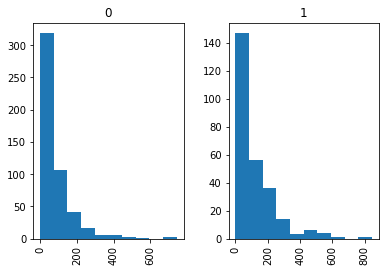

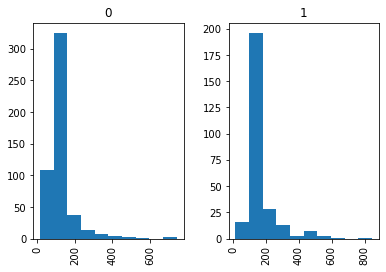

In [240]:
# 
print('Before imputing: ', d.Insulin.hist(by=d.Outcome))

print('\n')
print('After imputing: ', d_new.Insulin.hist(by=d.Outcome))

<Figure size 432x288 with 0 Axes>

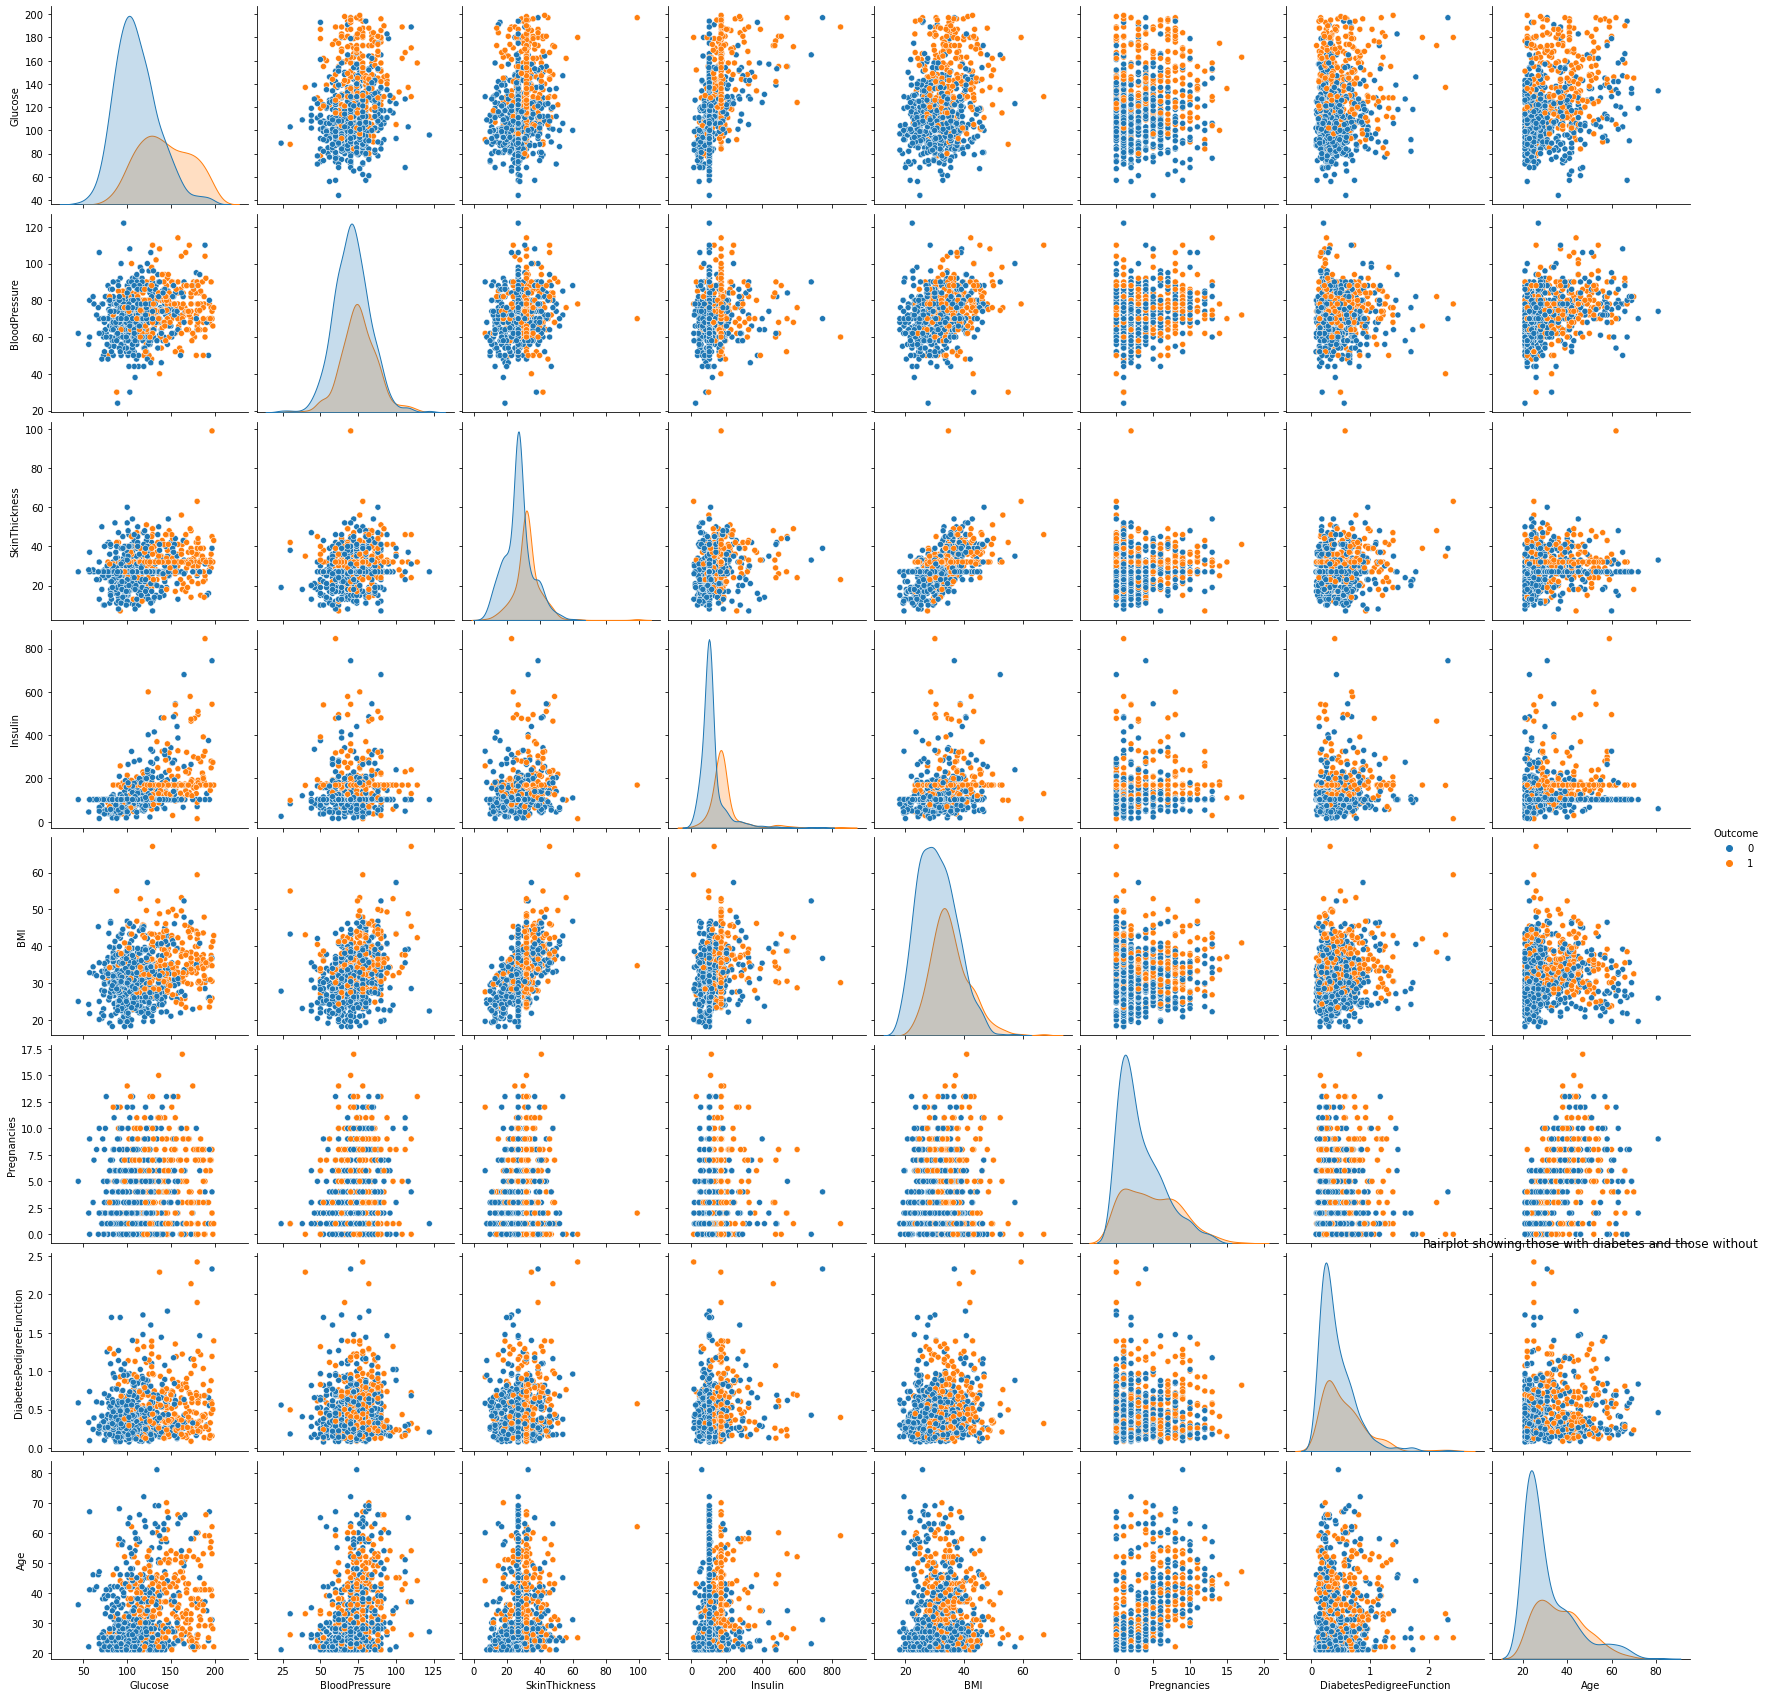

In [347]:
plt.figure()
sns.pairplot(d_new, hue = "Outcome", height=3)
plt.title('Pairplot showing those with diabetes and those without')
plt.show()

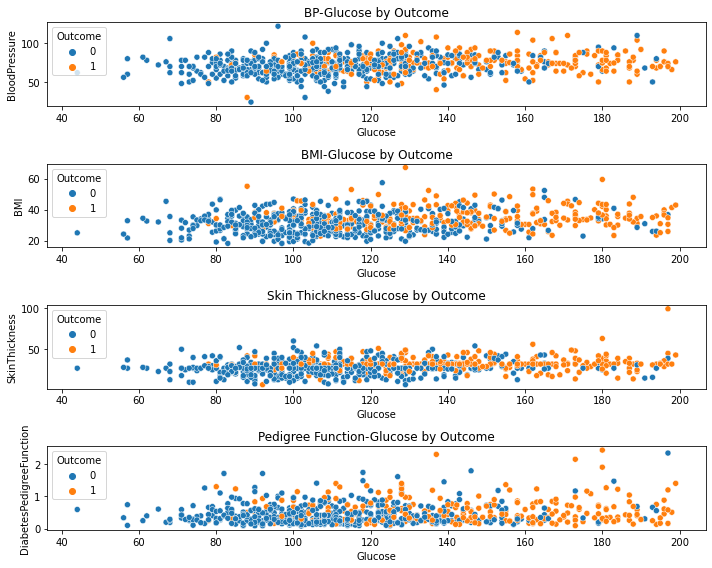

In [453]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize=(10,8))
sns.scatterplot(x=d_new.Glucose, y=d_new.BloodPressure,hue=d_new.Outcome, ax=ax1)
sns.scatterplot(x=d_new.Glucose, y=d_new.BMI,hue=d_new.Outcome,ax=ax2)
sns.scatterplot(x=d_new.Glucose, y=d_new.SkinThickness,hue=d_new.Outcome,ax=ax3)
sns.scatterplot(x=d_new.Glucose, y=d_new.DiabetesPedigreeFunction,hue=d_new.Outcome,ax=ax4)

ax1.set_title('BP-Glucose by Outcome')
ax2.set_title('BMI-Glucose by Outcome')
ax3.set_title('Skin Thickness-Glucose by Outcome')
ax4.set_title('Pedigree Function-Glucose by Outcome')

plt.tight_layout();
plt.show();

In [ ]:
d_new.to_csv('cleaned.csv')

<AxesSubplot:>

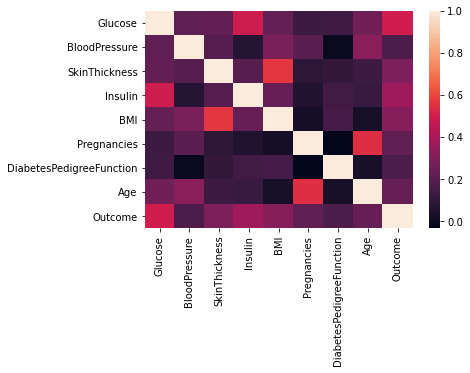

In [113]:
corr=d_new.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [109]:
d_new.corr() >.28

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DiabetesPedigreeFunction,Age,Outcome
Glucose,True,False,False,True,False,False,False,False,True
BloodPressure,False,True,False,False,True,False,False,True,False
SkinThickness,False,False,True,False,True,False,False,False,True
Insulin,True,False,False,True,False,False,False,False,True
BMI,False,True,True,False,True,False,False,False,True
Pregnancies,False,False,False,False,False,True,False,True,False
DiabetesPedigreeFunction,False,False,False,False,False,False,True,False,False
Age,False,True,False,False,False,True,False,True,False
Outcome,True,False,True,True,True,False,False,False,True


# END OF EDA # 
---
## Modeling

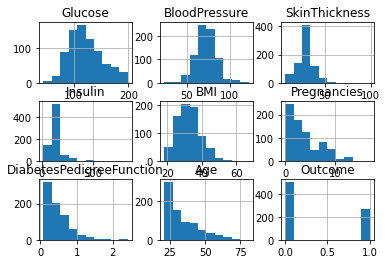

In [94]:
d_new.hist();

In [76]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

## First some basic linear/logistic regressions

In [454]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [455]:
linreg=LinearRegression()
linreg.fit(X_train, y_train)
linreg.coef_

array([0.15687748, 0.00219796, 0.06357321, 0.0743913 , 0.03663437,
       0.06060071, 0.06433868, 0.02354483])

In [456]:
linreg.intercept_

0.34241245136186765

In [457]:
from statsmodels.formula.api import ols
model = ols(data=d_new, formula='Outcome~Glucose+SkinThickness+Insulin+BMI+Pregnancies+DiabetesPedigreeFunction+Age').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     56.44
Date:                Wed, 30 Sep 2020   Prob (F-statistic):           4.92e-65
Time:                        20:58:50   Log-Likelihood:                -359.92
No. Observations:                 768   AIC:                             735.8
Df Residuals:                     760   BIC:                             773.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.0223      0.086    -11.923      0.000      -1.191      -0.854
Glucose                      0.0053      0.001      9.561      0.000       0.004       0.006
SkinThickness                0.0047      0.002      2.395      0.017       0.001       0.008
Insulin                      0.0007      0.000      4.009      0.000       0.000       0.001
BMI                          0.0095      0.003      3.764      0.000       0.005       0.014
Pregnancies                  0.0202      0.005      4.049      0.000       0.010       0.030
DiabetesPedigreeFunction     0.1158      0.043      2.675      0.008       0.031       0.201
Age                          0.0014      0.001      0.980      0.328      -0.001       0.004
==============================================================================
Omnibus:                       10.937   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                9.721
Skew:                           0.217   Prob(JB):                      0.00775
Kurtosis:                       2.659   Cond. No.                     1.29e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Feature engineering: polynomial features, 2nd degree

In [459]:
poly = PolynomialFeatures(degree=2, include_bias=False)
polydata = poly.fit_transform(d_new)
polycols = poly.get_feature_names(d_new.columns)
polydf = pd.DataFrame(data=polydata, columns=polycols)
polydf.head()

polyX = polydf.drop(columns='Outcome', axis=1)
polyy = polydf.Outcome

X_train, X_test, y_train, y_test = train_test_split(
    polyX, polyy, random_state=7,test_size=0.33)

lr = LinearRegression()
lr.fit(X_train,y_train)
testpred = lr.predict(X_test)

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Testing Root Mean Squared Error: 6.509806175027864e-15


In [460]:
polyX.shape

(768, 53)

In [461]:
selector = SelectKBest(f_regression, k=20)
selector.fit(X_train, y_train)
selected_columns = X_train.columns[selector.get_support()]
selected_columns

Index(['Glucose', 'Glucose^2', 'Glucose BloodPressure',
       'Glucose SkinThickness', 'Glucose Insulin', 'Glucose BMI',
       'Glucose Age', 'Glucose Outcome', 'BloodPressure Insulin',
       'BloodPressure Outcome', 'SkinThickness Insulin',
       'SkinThickness Outcome', 'Insulin BMI', 'Insulin Pregnancies',
       'Insulin Age', 'Insulin Outcome', 'BMI Outcome', 'Pregnancies Outcome',
       'DiabetesPedigreeFunction Outcome', 'Age Outcome'],
      dtype='object')

In [462]:
lrkbest = LinearRegression()
lrkbest.fit(X_train[selected_columns], y_train)
testpred = lrkbest.predict(X_test[selected_columns])
trainpred = lrkbest.predict(X_train[selected_columns])
testrmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))
trainrmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))
print(trainrmse)
print('Testing Root Mean Squared Error:' , testrmse)

0.04873637819792625
Testing Root Mean Squared Error: 0.05092669848197648


---

###  logistic regression

In [465]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [471]:
lr0 = LogisticRegression(solver='liblinear', random_state=7)
lr0.fit(X_train, y_train)
testpreds=lr0.predict(X_test)
trainpreds=lr0.predict(X_train)
print('Logistic Regression')
print('------------------')
print('\r')

print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpreds)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpreds)

Logistic Regression
------------------

Training Metrics:
------------------
Precision Score: 0.7272727272727273
Recall Score: 0.5909090909090909
Accuracy Score: 0.7840466926070039
F1 Score: 0.6520376175548589

Test Metrics:
------------------
Precision Score: 0.7126436781609196
Recall Score: 0.6739130434782609
Accuracy Score: 0.7834645669291339
F1 Score: 0.6927374301675977


In [477]:
# log reg ridge 'l2', other features I think are good 
lrlasso = LogisticRegressionCV(solver='liblinear',cv=15,penalty='l2',scoring='f1',class_weight='balanced',n_jobs=-1, random_state=7)

lrlasso.fit(X_train, y_train)
testpred=lrlasso.predict(X_test)
trainpred=lrlasso.predict(X_train)

print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpred)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpred)


Training Metrics:
------------------
Precision Score: 0.6745283018867925
Recall Score: 0.8125
Accuracy Score: 0.8015564202334631
F1 Score: 0.7371134020618556

Test Metrics:
------------------
Precision Score: 0.6637931034482759
Recall Score: 0.8369565217391305
Accuracy Score: 0.7874015748031497
F1 Score: 0.7403846153846154


In [489]:
logreg = LogisticRegression(solver='liblinear',random_state=7)

param = {'penalty': ['l1', 'l2'],
        'class_weight': [None, 'balanced'],
        'C': [.1,.5,1.0]}
gs = GridSearchCV(logreg, param, cv=15, scoring='f1')
gs.fit(X_train,y_train)

GridSearchCV(cv=15,
             estimator=LogisticRegression(random_state=7, solver='liblinear'),
             param_grid={'C': [0.1, 0.5, 1.0],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2']},
             scoring='f1')

In [480]:
testpred = gs.predict(X_test)
trainpred = gs.predict(X_train)

print('Grid Search for Logistic Regression')
print('------------------')
print('\r')
print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpred)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpred)



Grid Search for Logistic Regression
------------------

Training Metrics:
------------------
Precision Score: 0.6743119266055045
Recall Score: 0.8352272727272727
Accuracy Score: 0.8054474708171206
F1 Score: 0.7461928934010152

Test Metrics:
------------------
Precision Score: 0.6416666666666667
Recall Score: 0.8369565217391305
Accuracy Score: 0.7716535433070866
F1 Score: 0.7264150943396227


In [481]:
print(gs.best_params_) 

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}


### log reg with sampling to deal with target class imbalance

In [482]:
# None class weight 
lr = LogisticRegression(solver='liblinear', class_weight='balanced')
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
trpreds=lr.predict(X_train)
print('Training Metrics:')
print('------------------')
print_metrics(y_train, trpreds)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, preds)

Training Metrics:
------------------
Precision Score: 0.676056338028169
Recall Score: 0.8181818181818182
Accuracy Score: 0.8035019455252919
F1 Score: 0.7403598971722365

Test Metrics:
------------------
Precision Score: 0.6637931034482759
Recall Score: 0.8369565217391305
Accuracy Score: 0.7874015748031497
F1 Score: 0.7403846153846154


### upsampling the minority class 

In [483]:
has_diabetes = d_new[d_new.Outcome==1]
no_diabetes = d_new[d_new.Outcome==0]

upsampled = resample(has_diabetes, replace=True, n_samples=len(no_diabetes), random_state=7)
upsampled = pd.concat([no_diabetes, upsampled])
upsampled.Outcome.value_counts()

1    500
0    500
Name: Outcome, dtype: int64

In [484]:
# new train sets 
upnew_X = upsampled.drop(columns='Outcome', axis=1)
upnew_y = upsampled.Outcome
upX_train, upX_test, upy_train, upy_test = train_test_split(
    upnew_X, upnew_y, random_state=7,test_size=0.33)

# log reg model with upsampled minority class
upsampled_lr = LogisticRegression(solver='liblinear')
upsampled_lr.fit(upX_train, upy_train)
trainpred = upsampled_lr.predict(upX_train)
testpred = upsampled_lr.predict(upX_test)

print('Training Metrics:')
print('------------------')
print_metrics(upy_train, trainpred)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(upy_test, testpred)

Training Metrics:
------------------
Precision Score: 0.7716049382716049
Recall Score: 0.7692307692307693
Accuracy Score: 0.7776119402985074
F1 Score: 0.7704160246533127

Test Metrics:
------------------
Precision Score: 0.87248322147651
Recall Score: 0.7428571428571429
Accuracy Score: 0.806060606060606
F1 Score: 0.8024691358024693


In [485]:
cross_val_score(upsampled_lr, new_X_train, new_y_train)

array([0.78 , 0.765, 0.825, 0.82 , 0.805])

### downsample majority 

In [486]:
downsample = resample(no_diabetes, replace=False, n_samples=len(has_diabetes), random_state=7)
downsample = pd.concat([downsample, has_diabetes])
downsample.Outcome.value_counts()

1    268
0    268
Name: Outcome, dtype: int64

In [487]:
# new train sets 
downnew_X = downsample.drop(columns='Outcome', axis=1)
downnew_y = downsample.Outcome
dX_train, dX_test, dy_train, dy_test = train_test_split(
    downnew_X, downnew_y, random_state=7,test_size=0.33)


# log reg model with upsampled minority class
downsample_lr = LogisticRegression(solver='liblinear')
downsample_lr.fit(dX_train, dy_train)
trainpred = downsample_lr.predict(dX_train)
testpred = downsample_lr.predict(dX_test)

print('Training Metrics:')
print('------------------')
print_metrics(dy_train, trainpred)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(dy_test, testpred)

Training Metrics:
------------------
Precision Score: 0.8022598870056498
Recall Score: 0.797752808988764
Accuracy Score: 0.8022284122562674
F1 Score: 0.8000000000000002

Test Metrics:
------------------
Precision Score: 0.8064516129032258
Recall Score: 0.8333333333333334
Accuracy Score: 0.8135593220338984
F1 Score: 0.819672131147541


In [132]:
# SMOTE 

In [133]:
from imblearn.over_sampling import SMOTE

In [194]:
sm = SMOTE(k_neighbors=10, random_state=7)
smX_train, smy_train = sm.fit_sample(X_train, y_train)

smotelr = LogisticRegression(solver='liblinear')
smotelr.fit(smX_train, smy_train)
smotepred=smotelr.predict(X_test)
print_metrics(y_test, smotepred)

Precision Score: 0.6759259259259259
Recall Score: 0.7934782608695652
Accuracy Score: 0.7874015748031497
F1 Score: 0.7300000000000001


---
## Trees and Forests 

#### Random Forest

In [488]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
test_preds = rf.predict(X_test)
train_preds = rf.predict(X_train)

print('Training Metrics:')
print('------------------')
print_metrics(y_train, train_preds)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, test_preds)

Training Metrics:
------------------
Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0

Test Metrics:
------------------
Precision Score: 0.8588235294117647
Recall Score: 0.7934782608695652
Accuracy Score: 0.8779527559055118
F1 Score: 0.8248587570621468


### Decision Tree
- Sample run and grid search cv 

In [166]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
test_preds = dt.predict(X_test)
train_preds = dt.predict(X_train)

print('Training Metrics:')
print('------------------')
print_metrics(y_train, train_preds)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, test_preds)

Training Metrics:
------------------
Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0

Test Metrics:
------------------
Precision Score: 0.7764705882352941
Recall Score: 0.717391304347826
Accuracy Score: 0.8228346456692913
F1 Score: 0.7457627118644068


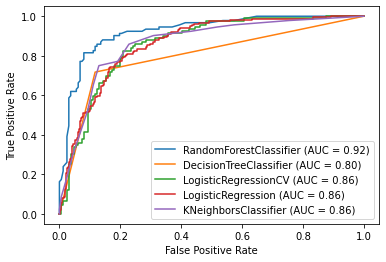

In [278]:
fig,ax=plt.subplots()
plot_roc_curve(rf, X_test, y_test, ax=ax)
plot_roc_curve(dt, X_test, y_test, ax=ax)
plot_roc_curve(lrlasso, X_test, y_test, ax=ax)
plot_roc_curve(upsampled_lr, upnew_X_train, upnew_y_train, ax=ax)
plot_roc_curve(knn, X_test, y_test, ax=ax)

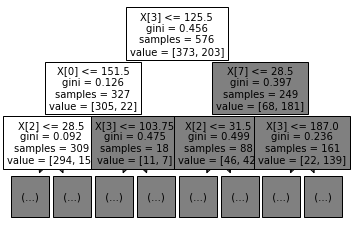

In [73]:
from sklearn import tree
tree.plot_tree(dt.fit(X_train, y_train), max_depth=2, fontsize=10);

In [58]:
corr = d.corr()

<AxesSubplot:>

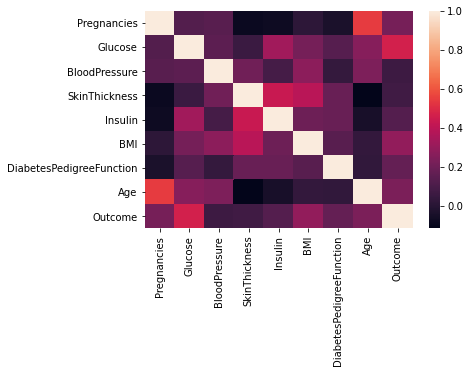

In [59]:
sns.heatmap(corr)

## Voting classifer

In [423]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [424]:
# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = RandomForestClassifier()
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2)],voting='soft')


In [425]:
clf1.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4)

In [426]:
ytrainpreds=clf1.predict(X_train)
ytestpreds=clf1.predict(X_test)

In [427]:
# dtc test f1 
f1_score(y_test,ytestpreds)

0.8021978021978022

In [428]:
# knn 12 f1
clf2.fit(X_train,y_train)
ytrainpreds=clf2.predict(X_train)
ytestpreds=clf2.predict(X_test)
print_metrics(y_test,ytestpreds)

Precision Score: 0.8505747126436781
Recall Score: 0.8043478260869565
Accuracy Score: 0.8779527559055118
F1 Score: 0.8268156424581005


In [430]:
# voting classfier soft 
eclf.fit(X_train,y_train)
ytrainpreds=eclf.predict(X_train)
ytestpreds=eclf.predict(X_test)
print_metrics(y_test,ytestpreds)

Precision Score: 0.8202247191011236
Recall Score: 0.7934782608695652
Accuracy Score: 0.8622047244094488
F1 Score: 0.8066298342541436


In [431]:
rl = RandomForestClassifier(n_jobs= -1, verbose=1)

In [432]:
rscv=RandomizedSearchCV(estimator=rl, param_distributions=param, cv=10)
rscv.fit(X_train,y_train)

ValueError: Invalid parameter weights for estimator RandomForestClassifier(n_jobs=-1, verbose=1). Check the list of available parameters with `estimator.get_params().keys()`.

In [180]:
rscv.best_params_

{'n_estimators': 20,
 'max_features': 'sqrt',
 'max_depth': 6,
 'class_weight': None}

In [189]:
# rscv 
rscv.score(X_test,y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


0.8489583333333334

### Random Forest GridSeachCV

In [247]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [251]:
rf=RandomForestClassifier(criterion='entropy', n_jobs=-1)

param = {'n_estimators': [5,10,20,30,50,100],
         'max_features': ['auto', 'sqrt', 'log2'],
         'max_depth' : [3,4,5,6,7,8,9],
         'class_weight': [None, 'balanced', 'balanced_subsample']}

gscv=GridSearchCV(rf,param_grid=param, cv=7)


In [252]:
param = {'n_estimators': [5,10,20,30,50,100],
         'max_features': ['auto', 'sqrt', 'log2'],
         'max_depth' : [3,4,5,6,7,8,9],
         'class_weight': [None, 'balanced', 'balanced_subsample']}

In [253]:
gscv=GridSearchCV(rf,param_grid=param, cv=7)


In [254]:
gscv.fit(X_train,y_train)

GridSearchCV(cv=7,
             estimator=RandomForestClassifier(criterion='entropy', n_jobs=-1),
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [5, 10, 20, 30, 50, 100]})

In [333]:
testpred = gscv.predict(X_test)
trainpred = gscv.predict(X_train)
print_metrics(y_train, trainpred)

Precision Score: 1.0
Recall Score: 0.9943181818181818
Accuracy Score: 0.9980544747081712
F1 Score: 0.9971509971509972


In [279]:
trainpred = gscv.predict(X_train)
testpred = gscv.predict(X_test)

print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpred)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpred)

Training Metrics:
------------------
Precision Score: 1.0
Recall Score: 0.9943181818181818
Accuracy Score: 0.9980544747081712
F1 Score: 0.9971509971509972

Test Metrics:
------------------
Precision Score: 0.8539325842696629
Recall Score: 0.8260869565217391
Accuracy Score: 0.8858267716535433
F1 Score: 0.8397790055248618


In [282]:
gscv.best_params_

{'class_weight': None,
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 30}

In [301]:
rf = RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=30, max_features='auto', random_state=7)
rf.fit(X_train,y_train)
b=rf.predict(X_test)
x=rf.predict(X_train)
print('Training Metrics:')
print('------------------')
print_metrics(y_train, x)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, b)

Training Metrics:
------------------
Precision Score: 0.9261363636363636
Recall Score: 0.9261363636363636
Accuracy Score: 0.9494163424124513
F1 Score: 0.9261363636363636

Test Metrics:
------------------
Precision Score: 0.8241758241758241
Recall Score: 0.8152173913043478
Accuracy Score: 0.8700787401574803
F1 Score: 0.8196721311475409


## KNN 
- using python to find best n_neighbor, taken from Sean's lecture 

In [244]:
def max_value(l):
    max_val = max(l)
    max_idx = l.index(max_val)
    return max_idx, max_val

In [245]:
#create a container to track the scores
k_scores=[]

#set up a loop to fit the model using a different values of K

k_range = list(range(1, 21))
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    #fit the model and get the score on a evaluation metric
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    k_scores.append(acc)
    

#use the max_value function to find the K value that gives you the best accuracy pred 
idx, val = max_value(k_scores)

    
print(idx+1, val)

15 0.8267716535433071


In [276]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [277]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
trainpred = knn.predict(X_train)
testpred = knn.predict(X_test)
print_metrics(y_train, trainpred)
print('\n')
print_metrics(y_test, testpred)

Precision Score: 0.8012422360248447
Recall Score: 0.7329545454545454
Accuracy Score: 0.8463035019455253
F1 Score: 0.7655786350148367


Precision Score: 0.7666666666666667
Recall Score: 0.75
Accuracy Score: 0.8267716535433071
F1 Score: 0.7582417582417583


### KNN with GridSearchCV

In [304]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [338]:
knn = KNeighborsClassifier()

In [339]:
param = {'n_neighbors': range(0,18,1),
        'weights': ['uniform', 'distance'],
        'metric': ['manhattan', 'euclidean', 'minokwski']}

In [340]:
gs = GridSearchCV(knn, param, cv=7, scoring='f1', n_jobs=-1)

In [341]:
gs.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean', 'minokwski'],
                         'n_neighbors': range(0, 18),
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [345]:
print(gs.best_params_)
print(gs.best_estimator_)

{'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'uniform'}
KNeighborsClassifier(metric='manhattan', n_neighbors=17)


In [346]:
testpreds=gs.predict(X_test)
trainpreds=gs.predict(X_train)


print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpreds)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpreds)


Training Metrics:
------------------
Precision Score: 0.8535031847133758
Recall Score: 0.7613636363636364
Accuracy Score: 0.8735408560311284
F1 Score: 0.8048048048048047

Test Metrics:
------------------
Precision Score: 0.7888888888888889
Recall Score: 0.7717391304347826
Accuracy Score: 0.84251968503937
F1 Score: 0.7802197802197802
